In [1]:
import numpy as np
import pandas as pd
import operator
import pickle
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_validate as cross_validation
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn import linear_model

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import RandomOverSampler, SMOTE
import warnings
warnings.filterwarnings(action='once')
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from itertools import cycle
from matplotlib.font_manager import FontProperties

In [2]:
#with open('../../Data/Opioids/Model_Data/Age_Condensed/subjects_with_side_effects.pickle', 'rb') as pickler:
 #   subjects_with_side_effects = pickle.load(pickler)
#with open('../../Data/Opioids/Model_Data/Age_Condensed/subjects_without_side_effects.pickle', 'rb') as pickler:
  #  subjects_without_side_effects = pickle.load(pickler)
#with open('../../Data/Opioids/Model_Data/Age_Condensed/data.pickle', 'rb') as pickler:
 #   data = pickle.load(pickler)
subjects_with_side_effects = pd.read_pickle('../../../Data/Opioids/Model_Data/Age_Condensed/subjects_with_side_effects.pickle')
subjects_without_side_effects = pd.read_pickle('../../../Data/Opioids/Model_Data/Age_Condensed/subjects_without_side_effects.pickle')
data = pd.read_pickle('../../../Data/Opioids/Model_Data/Age_Condensed/data.pickle')

D:\Anaconda3\envs\emitter\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
#Quick reference to have SUBJECT_ID in data
#data = subjects_with_side_effects.append(subjects_without_side_effects)
data = data.sample(frac=1).reset_index(drop=True)
#len(data)
X = data[['GENDER', 'EXPIRE_FLAG', 'TOTAL_NARCOTIC_PRESCRIPTONS',
       'TOTAL_ANTI_NARCOTIC_PRESCRIPTONS', 'NARCOTIC', 'ANTI-NARCOTIC',
       'ICU_STAY', 'OXYMORPHONE', 'OXYCODONE', 'MORPHINE', 'MEPERIDINE',
       'HYDROMORPHONE', 'HYDROCODONE', 'FENTANYL', 'CODEINE', 'BUPRENORPHINE',
       'METHADONE', 'NALOXONE', 'AGE_1', 'AGE_2', 'AGE_3', 'AGE_4', 'AGE_5', 'AGE_6', 'AGE_7', 'AGE_8']]
y = data[['SIDE_EFFECTS_FLAG']]
#y = y.as_matrix()
y = y.values
y = y.reshape(20703,)

D:\Anaconda3\envs\emitter\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
y

array([0., 0., 0., ..., 0., 0., 0.])

### PCA Fit & Upsampling Minority Class Data With SMOTE

In [5]:
len(y)

20703

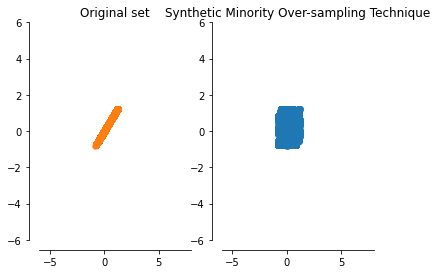

In [6]:
# Instanciate a PCA object for the sake of easy visualisation
pca = PCA()
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X)

# Apply the random over-sampling
#ros = RandomOverSampler(ratio='minority')
#X_resampled, y_resampled = ros.fit_sample(X, y)
sampler = SMOTE()
X_resampled, y_resampled = sampler.fit_resample(X, y)
X_res_vis = pca.transform(X_resampled)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2)

#c0 = ax1.scatter(X_vis[y == 0], X_vis[y == 0], label="Class 0 (Without Side Effects)",
 #                alpha=0.5)
#c1 = ax1.scatter(X_vis[y == 1], X_vis[y == 1], label="Class 1 (With Side Effects)",
 #                alpha=0.5)
c0 = ax1.scatter(X_vis[y == 0], X_vis[y == 0], label="Class 0 (Without Side Effects)", alpha=0.5)
c1 = ax1.scatter(X_vis[y == 1], X_vis[y == 1], label="Class 1 (With Side Effects)", alpha=0.5)
ax1.set_title('Original set')

#ax2.scatter(X_res_vis[y_resampled == 0], X_res_vis[y_resampled == 1], label="Class 0 (Without Side Effects)", alpha=.5)
ax2.scatter(X_res_vis[y_resampled == 0], X_res_vis[y_resampled == 1], label="Class 1 (With Side Effects)", alpha=.5)
ax2.set_title('Synthetic Minority Over-sampling Technique')

for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-6, 8])
    ax.set_ylim([-6, 6])

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X_res_vis, y_resampled, test_size=0.2, random_state=42)

# The above returns numpy arrays. Converting them to data frames:
X_train = pd.DataFrame(X_train)   
X_test = pd.DataFrame(X_test)   
Y_train = pd.Series(Y_train)    
Y_test = pd.Series(Y_test)

In [11]:
X_res_vis.shape

(39938, 26)

In [13]:
warnings.filterwarnings('ignore')
predicted = cross_val_predict(LogisticRegression(), X_res_vis, y_resampled, cv=10)
print(metrics.classification_report(y_resampled, predicted))
print("Accuracy Score: %f" %(metrics.accuracy_score(y_resampled, predicted)))

              precision    recall  f1-score   support

         0.0       0.76      0.79      0.78     19969
         1.0       0.78      0.75      0.77     19969

    accuracy                           0.77     39938
   macro avg       0.77      0.77      0.77     39938
weighted avg       0.77      0.77      0.77     39938

Accuracy Score: 0.771671


In [14]:
tn, fp, fn, tp = metrics.confusion_matrix(y_resampled, predicted).ravel()
#print(tn, fp, fn, tp)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
npv = tn/(tn+fn)
f1_score = (2*precision*recall)/(precision + recall)
print("Precision (PPV): ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)
print("NPV: ", npv)
print("Accuracy: ", (metrics.accuracy_score(y_resampled, predicted)))

Precision (PPV):  0.7845080763582967
Recall:  0.7491111222394712
F1 score:  0.7664011066424161
NPV:  0.7599425011978918
Accuracy:  0.7716710901897942


In [83]:
# X.to_pickle('../../Data/Opioids/Model_Data/SMOTE/X.pickle')
# y.dump('../../Data/Opioids/Model_Data/SMOTE/y.pickle')
# X_resampled.dump('../../Data/Opioids/Model_Data/SMOTE/X_resampled.pickle')
# y_resampled.dump('../../Data/Opioids/Model_Data/SMOTE/y_resampled.pickle')
# X_res_vis.dump('../../Data/Opioids/Model_Data/SMOTE/X_res_vis.pickle')
# X_vis.dump('../../Data/Opioids/Model_Data/SMOTE/X_vis.pickle')
# X_train.to_pickle('../../Data/Opioids/Model_Data/SMOTE/X_train.pickle')
# Y_train.to_pickle('../../Data/Opioids/Model_Data/SMOTE/Y_train.pickle')
# X_test.to_pickle('../../Data/Opioids/Model_Data/SMOTE/X_test.pickle')
# Y_test.to_pickle('../../Data/Opioids/Model_Data/SMOTE/Y_test.pickle')

In [43]:
# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=1)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X)

# Apply the random over-sampling
#ros = RandomOverSampler(ratio='minority')
#X_resampled, y_resampled = ros.fit_sample(X, y)
sampler = SMOTE()
X_resampled, y_resampled = sampler.fit_resample(X, y)
X_res_vis = pca.transform(X_resampled)

### With PCA

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_vis, y, test_size=0.2, random_state=42)

# The above returns numpy arrays. Converting them to data frames:
X_train = pd.DataFrame(X_train)   
X_test = pd.DataFrame(X_test)   
Y_train = pd.Series(Y_train)    
Y_test = pd.Series(Y_test)

In [18]:
warnings.filterwarnings('ignore')
predicted = cross_val_predict(LogisticRegression(), X_vis, y, cv=10)
print("Accuracy Score: %f" %(metrics.accuracy_score(y, predicted)))
print(metrics.classification_report(y, predicted))

Accuracy Score: 0.965029
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     19969
         1.0       0.55      0.08      0.14       734

    accuracy                           0.97     20703
   macro avg       0.76      0.54      0.56     20703
weighted avg       0.95      0.97      0.95     20703



In [19]:
tn, fp, fn, tp = metrics.confusion_matrix(y, predicted).ravel()
#print(tn, fp, fn, tp)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
npv = tn/(tn+fn)
f1_score = (2*precision*recall)/(precision + recall)
print("Precision (PPV): ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)
print("NPV: ", npv)
print("Accuracy: ", (metrics.accuracy_score(y, predicted)))

Precision (PPV):  0.5454545454545454
Recall:  0.08174386920980926
F1 score:  0.14218009478672985
NPV:  0.9672704317000923
Accuracy:  0.9650292228179491


## Dropping AGE_x Columns

In [37]:
data = pd.read_pickle('../../Data/Opioids/Model_Data/Age_Condensed/data.pickle')
X = data[['GENDER', 'EXPIRE_FLAG', 'TOTAL_NARCOTIC_PRESCRIPTONS','TOTAL_ANTI_NARCOTIC_PRESCRIPTONS', 'NARCOTIC', 'ANTI-NARCOTIC','HYDROMORPHONE', 'HYDROCODONE', 'FENTANYL', 'CODEINE', 'BUPRENORPHINE','METHADONE', 'NALOXONE', 'AGE_3', 'AGE_4', 'AGE_5', 'AGE_6']]
y = data[['SIDE_EFFECTS_FLAG']]
y = y.to_numpy()
y = y.reshape(20703,)

In [38]:
# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=1)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X)

# Apply the random over-sampling
#ros = RandomOverSampler(ratio='minority')
#X_resampled, y_resampled = ros.fit_sample(X, y)
sampler = SMOTE()
X_resampled, y_resampled = sampler.fit_resample(X, y)
X_res_vis = pca.transform(X_resampled)

In [39]:
y_resampled_series = pd.Series(y_resampled)
y_resampled_series = y_resampled_series.map({0.0:'A', 1.0:'P'})
y_df = pd.DataFrame(columns=["TARGET"])
y_df["TARGET"] = y_resampled_series
#y_df["TARGET"] = y_df["TARGET"].astype('category', categories=['A','P'])
y_df["TARGET"] = pd.Categorical(y_df["TARGET"], categories=['A','P'])
y_enc = pd.get_dummies(y_df["TARGET"])
y_enc.columns=["ABSENT", "PRESENT"]
len(y_enc)

39938

In [40]:
y_enc = y_enc.to_numpy()
len(data)

20703

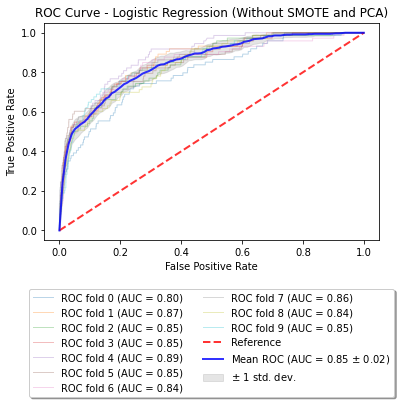

In [24]:
X_cv = X.to_numpy()
cv = StratifiedKFold(n_splits=10)
classifier = LogisticRegression()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    
    probas_ = classifier.fit(X_cv[train], y[train]).predict_proba(X_cv[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Reference', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Without SMOTE and PCA)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),  shadow=True, ncol=2)
plt.savefig('lr_r0c_1')
plt.show()

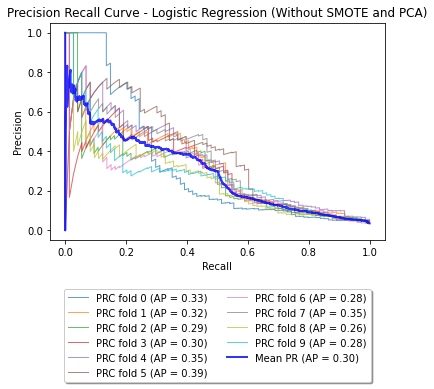

In [23]:
X_cv = X.to_numpy()
cv = StratifiedKFold(n_splits=10)
classifier = LogisticRegression()

precision_scores = []
aucs = []
mean_recall = np.linspace(0, 1, 100)

y_test_cv = []
y_proba_cv = []

i = 0
for train, test in cv.split(X, y):
    
    probas_ = classifier.fit(X_cv[train], y[train]).predict_proba(X_cv[test])
    # Compute ROC curve and area the curve
    precision, recall, thresholds = metrics.precision_recall_curve(y[test], probas_[:, 1])
    precision_scores.append(interp(mean_recall, recall, precision))
    precision_scores[-1][0] = 0.0
    pr_auc = metrics.average_precision_score(y[test], probas_[:, 1])
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=1, alpha=0.7,
             label='PRC fold %d (AP = %0.2f)' % (i, pr_auc))
    y_test_cv.append(y_resampled[test])
    y_proba_cv.append(probas_[:, 1])

    i += 1


y_test_cv = np.concatenate(y_test_cv)
y_proba_cv = np.concatenate(y_proba_cv)
precision, recall, _ = metrics.precision_recall_curve(y_test_cv, y_proba_cv)
pr_auc = metrics.average_precision_score(y_test_cv, y_proba_cv)

plt.plot(recall, precision, color='b',
         label=r'Mean PR (AP = %0.2f)' % (pr_auc),
         lw=2, alpha=.8)


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve - Logistic Regression (Without SMOTE and PCA)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),  shadow=True, ncol=2)
plt.savefig('lr_prc_1')
plt.show()

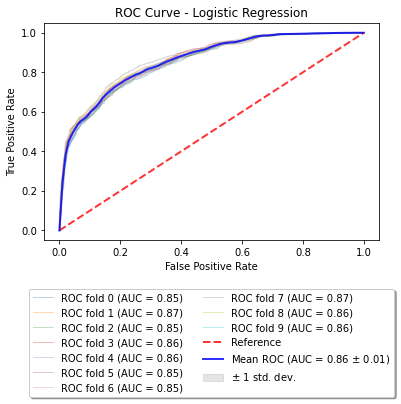

In [22]:
cv = StratifiedKFold(n_splits=10)
classifier = LogisticRegression()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X_res_vis, y_resampled):
    
    probas_ = classifier.fit(X_res_vis[train], y_resampled[train]).predict_proba(X_res_vis[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(y_resampled[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Reference', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),  shadow=True, ncol=2)
plt.savefig('lr_roc_2')
plt.show()

In [156]:
y_enc

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

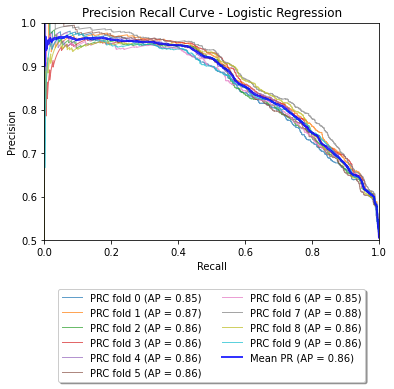

In [25]:
cv = StratifiedKFold(n_splits=10)
classifier = LogisticRegression()

precision_scores = []
aucs = []
mean_recall = np.linspace(0, 1, 100)

y_test_cv = []
y_proba_cv = []

i = 0
for train, test in cv.split(X_res_vis, y_resampled):
   
    probas_ = classifier.fit(X_res_vis[train], y_resampled[train]).predict_proba(X_res_vis[test])
    # Compute ROC curve and area the curve
    precision, recall, thresholds = metrics.precision_recall_curve(y_resampled[test], probas_[:, 1])
    precision_scores.append(interp(mean_recall, recall, precision))
    precision_scores[-1][0] = 0.0
    pr_auc = metrics.average_precision_score(y_resampled[test], probas_[:, 1])
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=1, alpha=0.7,
             label='PRC fold %d (AP = %0.2f)' % (i, pr_auc))
    y_test_cv.append(y_resampled[test])
    y_proba_cv.append(probas_[:, 1])

    i += 1



y_test_cv = np.concatenate(y_test_cv)
y_proba_cv = np.concatenate(y_proba_cv)
precision, recall, _ = metrics.precision_recall_curve(y_test_cv, y_proba_cv)
pr_auc = metrics.average_precision_score(y_test_cv, y_proba_cv)

plt.plot(recall, precision, color='b',
         label=r'Mean PR (AP = %0.2f)' % (pr_auc),
         lw=2, alpha=.8)


plt.xlim([0, 1.0])
plt.ylim([0.5, 1.0])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve - Logistic Regression')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),  shadow=True, ncol=2)
plt.savefig('lr_prc_2')
plt.show()